In [2]:
NOTEBOOK_NAME = 'model.ipynb'

In [3]:
import os
import tqdm
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn
import torchvision as tv

from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torchvision import datasets, transforms

from utils import save_pickle, load_pickle, ImageSearcher

In [4]:
EXP_NAME = 'efficientnet'
ARTIFCAT_PATH = os.path.join(EXP_NAME, 'artifacts')
os.makedirs(ARTIFCAT_PATH, exist_ok=True)

In [5]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

In [6]:
searcher = ImageSearcher('train')

## Dataset

In [7]:
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        files = os.listdir(self.folder)
        self.labels = ['.'.join(e.split('.')[:-1]) for e in files]
        self.files = [os.path.join(folder, f) for f in files]
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image_path = self.files[idx]
        image = tv.io.read_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return (image, label)

In [8]:
IMAGE_SIZE = 480


ds_train = ImageLoader(
    folder='torch_data/train',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

ds_val = ImageLoader(
    folder='torch_data/val',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

In [9]:
train_loader = torch.utils.data.DataLoader(
    ds_train,
    64,
)

val_loader = torch.utils.data.DataLoader(
    ds_val,
    64,
)

## Model

In [10]:
model = efficientnet.efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Identity()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
model = model.to(device)

## Embeddings

In [23]:
def collect_preds(module, loader):
    x_all = []
    y_all = []
    for x, y in tqdm.tqdm(loader):
        with torch.no_grad():
            x = model(x.to(device)).cpu().numpy()
            x_all.append(x)
            y_all.append(y)
            
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    
    return x_all, y_all

### computing embeddings

In [24]:
x_train, y_train = collect_preds(model, train_loader)
x_val, y_val = collect_preds(model, val_loader)

100%|██████████| 109/109 [05:19<00:00,  2.93s/it]


In [34]:
save_pickle([x_train, y_train], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
save_pickle([x_val, y_val], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

# RAM images

In [61]:
ds = ImageLoader(
    folder='train',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

In [69]:
# res = []
for i in tqdm(range(5701, len(ds))):
    res.append(ds[i])

  0%|          | 0/4212 [00:00<?, ?it/s]

In [75]:
img_ids = [e[1] for e in res]
img_data = [e[0] for e in res]
id2img = dict(zip(img_ids, img_data))

# Model

In [27]:
import pandas as pd
from utils import load_pickle
from sklearn.metrics import mean_squared_error
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from tqdm.notebook import tqdm
import shutil

In [127]:
# def prepare_data(x, y, meta_all):
#     y = meta_all.set_index('Id').loc[y]['Pawpularity'].to_numpy()
#     y = y / 100
    
#     x = x.astype(np.float32)
#     y = y.astype(np.float32)

#     return x, y


def prepare_data(ids, meta_all, id2img):
    y = meta_all.set_index('Id').loc[ids]['Pawpularity'].to_numpy()
    y = y / 100
    
    x = [id2img[e] for e in ids]
    y = y.astype(np.float32)

    return x, y

In [29]:
meta_all = pd.read_csv('train.csv')

In [186]:
# x_train, y_train = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
# x_val, y_val = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

# x_train, y_train = prepare_data(x_train, y_train, meta_all)
# x_val, y_val = prepare_data(x_val, y_val, meta_all)

x_train, y_train = prepare_data(pd.read_csv('torch_data/train.csv')['Id'], meta_all, id2img)
x_val, y_val = prepare_data(pd.read_csv('torch_data/val.csv')['Id'], meta_all, id2img)

In [133]:
rmse = lambda yh, y: mean_squared_error(y, yh) ** 0.5

In [84]:
backbone = efficientnet.efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
backbone.classifier[1] = nn.Identity()
backbone = backbone.to(device)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [88]:
for p in backbone.parameters():
    p.requires_grad = False

In [187]:
def l1_reg(module: nn.Module):
    flat_weights = torch.cat([e.view(-1) for e in module.parameters()])
    flat_weights = torch.abs(flat_weights)
    loss = torch.sum(flat_weights)
    
    return loss

In [188]:
class RAMImagesDataset(data.Dataset):
    def __init__(self, x, y, transform=None):
        super().__init__()
        
        self.x = x
        self.y = np.array(y)[:, np.newaxis]
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        if self.transform is not None:
            x = self.transform(x)
            
        return x, self.y[idx]

In [189]:
class PawpularityHead(nn.Module):
    def __init__(self, in_dim, backbone):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(in_dim, 1)
        self.fc_act = nn.Sigmoid() # for test simplicity
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        x = self.fc_act(x)
        
        return x

In [205]:
def test(module, test_dl, metrics:dict):
    module = module.train(False)
    
    yh = []
    yt = []
    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(device)
            yhc = module(x).detach().cpu().numpy()
            yh.append(yhc)
            yt.append(y)
            
    yh = np.concatenate(yh, axis=0)
    y = np.concatenate(yt, axis=0)
    
    res = {}
    for mname, mfunc in metrics.items():
        res[mname] = mfunc(yh, y)
    
    return res

In [202]:
def train(
    module: nn.Module, 
    loss_f, 
    optimizer: torch.optim.Optimizer, 
    train_dl: data.DataLoader, 
    test_dl: data.DataLoader, 
    epochs: int,
    loss_alpha=0.01,
    pbar_update_steps: int=100,
    ):
    
    logs = []
    test_logs = []
    for epoch in range(epochs):
        module = module.train(True)
        with tqdm(total=len(train_dl)) as pbar:
            pbar.set_description(f'epoch {epoch}')
            
            for step, (x, y) in enumerate(train_dl):
                x = x.to(device)
                y = y.to(device)

                yh = module(x)
                loss = loss_f(yh, y)
#                 loss_reg = l1_reg(module)
                
#                 loss_full = loss + loss_alpha * loss_reg
                loss_full = loss
    
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                
                loss = loss.detach().cpu().numpy()
#                 loss_reg = loss_reg.detach().cpu().numpy()
                
                log = {
                    'loss' : float(loss), 
#                     'loss_reg': float(loss_reg),
                    'rmse': rmse(yh.detach().cpu().numpy(), y.detach().cpu().numpy()),
                }
                logs.append(log)
                
                if step % pbar_update_steps == 0:
                    running_loss = {
                        key: np.mean([log[key] for log in logs[-pbar_update_steps:]])
                        for key in log
                    }
                    pbar.set_postfix(running_loss)
                pbar.update()
        
        test_metrics = test(module, test_dl, {'rmse' : rmse})
        test_logs.append(test_metrics)
        print(test_metrics)
    
    return logs, test_logs

In [203]:
METRIC_COLLECTION_STEPS = 10
SUB_EXP_NAME = 'augmentation'
SUB_EXP_ARTIFACTS = os.path.join(ARTIFCAT_PATH, SUB_EXP_NAME)
os.makedirs(SUB_EXP_ARTIFACTS, exist_ok=True)

In [ ]:
model = PawpularityHead(EMB_SIZE, backbone)
model = model.to(device)
embs_dataset_train = RAMImagesDataset(x_train, y_train, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
    ]))
embs_dataset_val = RAMImagesDataset(x_val, y_val)

loader_train = data.DataLoader(embs_dataset_train, 64)
loader_val = data.DataLoader(embs_dataset_val, 64)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logs, test_logs = train(
    model, 
    loss_fn, 
    optimizer, 
    loader_train, 
    loader_val, 
    epochs=20, 
#     loss_alpha=0.001,
    pbar_update_steps=METRIC_COLLECTION_STEPS)

  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.18224165548313243}


  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
save_pickle(logs, os.path.join(SUB_EXP_ARTIFACTS, 'train_logs.pkl'))
save_pickle(test_logs, os.path.join(SUB_EXP_ARTIFACTS, 'test_logs.pkl'))
save_pickle(model.state_dict(), os.path.join(SUB_EXP_ARTIFACTS, 'state_dict.pkl'))

In [213]:
round(test_logs[-1]['rmse'], 4)

0.1797

In [231]:
train_logs_df = pd.DataFrame(logs)

test_logs_df = pd.DataFrame(test_logs)
test_logs_df.index = test_logs_df.index * len(loader_train) + METRIC_COLLECTION_STEPS

<AxesSubplot:xlabel='steps', ylabel='rmse'>

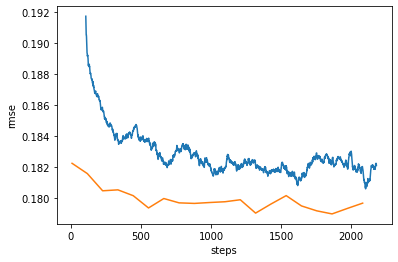

In [233]:
plt.xlabel('steps')
plt.ylabel('rmse')
train_logs_df['rmse'].rolling(len(loader_train)).mean().plot()
test_logs_df['rmse'].plot()
# plt.savefig(os.path.join(SUB_EXP_ARTIFACTS, 'rmse_plot.png'))

In [214]:
np.sum(np.abs(model.fc.weight.detach().cpu().numpy()[0]) < 1e-5)

0

(array([  4.,  14.,  81., 241., 395., 316., 170.,  44.,  13.,   2.]),
 array([-0.09628855, -0.07632322, -0.05635788, -0.03639254, -0.01642721,
         0.00353813,  0.02350347,  0.04346881,  0.06343415,  0.08339948,
         0.10336482], dtype=float32),
 <BarContainer object of 10 artists>)

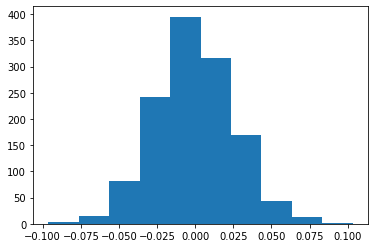

In [215]:
plt.hist(model.fc.weight.detach().cpu().numpy()[0])

In [216]:
shutil.copyfile(NOTEBOOK_NAME, os.path.join(SUB_EXP_ARTIFACTS, 'model.ipynb'))

'efficientnet/artifacts/augmentation/model.ipynb'